## Revisiting PCA with $n_1 n_2 r$ eighting:

We only use $M_h < 12.3$, so this might be better thistime with the weighting:

In [134]:
from gal_goku import summary_stats
import numpy as np
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt



class WeightedPCA:
    def __init__(self, fid='L2', n_components=5):
        self.fid = fid
        self.n_components = n_components   
        
        self.log_hmfs = []
        self.log_corr = []
        self.common_tags = []
        for narrow in [True, False]:
            data_dir = '/home/qezlou/HD2/HETDEX/cosmo/data/'
            hmf = summary_stats.HMF(data_dir=data_dir, fid=fid, narrow=narrow, logging_level='WARNING')
            data_dir = '/home/qezlou/HD2/HETDEX/cosmo/data/xi_on_grid/'
            self.xi = summary_stats.Xi(data_dir=data_dir, fid=fid, narrow=narrow, logging_level='WARNING')


    
            self.mbins, log_hmfs, _, _, sim_tags_hmf = hmf.get_wt_err()
            self.xi_bins, log_corr, _, _, _sim_tags_xi = self.xi.get_wt_err()

            self.mass_pairs = self.xi.mass_pairs
            self.rbins = np.unique(self.xi_bins[:, 2])

            common_tags, idx_hmf, idx_xi = np.intersect1d(sim_tags_hmf, _sim_tags_xi, return_indices=True)

            log_hmfs = log_hmfs[idx_hmf, :]
            log_corr = log_corr[idx_xi, :]
            self.log_hmfs.append(log_hmfs)
            self.log_corr.append(log_corr)
            self.common_tags.append(common_tags)
        
        self.log_hmfs = np.concatenate(self.log_hmfs, axis=0)
        self.log_corr = np.concatenate(self.log_corr, axis=0)
        self.common_tags = np.concatenate(self.common_tags, axis=0)

        print(f"Number of common tags: {len(self.common_tags)}")


        # Digitize the first two columns of xi_bins using mbins
        idx1 = np.digitize(self.xi_bins[:, 0], self.mbins) 
        idx2 = np.digitize(self.xi_bins[:, 1], self.mbins)
        n1n2 = 10**(self.log_hmfs[:,idx1]) * 10**(self.log_hmfs[:,idx2])


        self.weights = n1n2 * self.xi_bins[:, 2]**2
        print(f"n1n2 shape: {n1n2.shape}, log_hmfs shape: {self.log_hmfs.shape}, mbins shape: {self.mbins.shape}, indx1 shape: {idx1.shape}, indx2 shape: {idx2.shape}, weights shape: {self.weights.shape}")
        self.weights /= self.weights[0][-1]

        # Do the PCA
        self.X_reconstructed, self.pca, self.mean_w = self.do_pca(n_components=self.n_components)

        self.sub_sample_plot = np.random.choice(range(self.log_corr.shape[0]), size=5, replace=False)

    def do_pca(self, n_components=10):
        """
        Perform PCA on the log_corr data with weights.
        """
        # Original data
        X = 10**self.log_corr              # shape: (n_samples, n_features)
        W = self.weights                     # shape: (n_samples, n_features)

        # Mean-centering: use weighted mean for each feature
        weighted_sum = np.sum(X * W, axis=0)
        sum_weights = np.sum(W, axis=0)
        mean_w = weighted_sum / sum_weights  # shape: (n_features,)

        # Center the data
        X_centered = X - mean_w              # broadcast (n_samples, n_features)

        # Apply sqrt of weights to scale residuals
        X_weighted = X_centered * np.sqrt(W)

        # Apply PCA to this transformed data
        pca = PCA(n_components=n_components)
        pca.fit(X_weighted)

        # Transform and reconstruct
        X_proj = pca.transform(X_weighted)
        X_reconstructed_weighted = pca.inverse_transform(X_proj)

        # Undo weighting and re-add mean
        X_reconstructed = X_reconstructed_weighted / np.sqrt(W) + mean_w

        print("Cumulative Explained variance ratio:", np.cumsum(pca.explained_variance_ratio_))

        return X_reconstructed, pca, mean_w

    def get_mass_pair(self, corrs, mass_pair):
        """
        Get the indices of the correlation matrix.
        """
        ind = (self.xi_bins[:, 0] == mass_pair[0]) & (self.xi_bins[:, 1] == mass_pair[1])
        return corrs[:,ind]
    
    def get_at_rbins(self, corr, rbin):
        """
        Get the indices of the correlation matrix at specific rbins.
        corrs: 3D symmetric correlation function for one simulation
        rbin: float, the rbin value to extract
        3D array of shape (n_samples, n_m1, n_m2)
        where n_samples is the number of samples, n_m1 and n_m2 are the
        number of mass bins.
        Return:
        -----
        corr: 2D array of shape (n_m1, n_m2)
        """
        corr = corr.reshape((-1, self.rbins.size))

        corr = self.xi.make_3d_corr(corr, symmetric=True)

        closest_rbin = np.argmin(np.abs(self.rbins - rbin))

        return corr[:, :, closest_rbin]
    
    def transform(self, log_corr, W):
        """
        Transform the log_corr data using the PCA model.
        """
        X = 10**log_corr

        # Center the data by the already computed mean
        # Use the mean_w computed during PCA fitting
        X_centered = X - self.mean_w

        # Apply sqrt of weights to scale residuals
        X_weighted = X_centered * np.sqrt(W)

        # Transform using PCA
        X_proj = self.pca.transform(X_weighted) # shape: (n_new_samples, n_components)

        return X_proj
    
    def inverse_transform(self, X_proj, W):
        """
        Inverse transform the PCA projection back to the original space.
        """
        # Inverse transform using PCA
        X_reconstructed_weighted = self.pca.inverse_transform(X_proj)

        # Undo weighting and re-add mean
        X_reconstructed = X_reconstructed_weighted / np.sqrt(W) + self.mean_w

        return X_reconstructed

    def plot_pca(self, orig=None, reconstructed=None, mass_pair = (11.6, 11.6)):

        # Compare original vs reconstructed

        fig, ax = plt.subplots(1, 2, figsize=(16, 6))

        if orig is None:
            orig = self.get_mass_pair(10**self.log_corr, mass_pair)
            reconstructed = self.get_mass_pair(self.X_reconstructed, mass_pair)
        else:
            orig = self.get_mass_pair(orig, mass_pair)
            reconstructed = self.get_mass_pair(reconstructed, mass_pair)

        for i, ind in enumerate(self.sub_sample_plot):
            # First axis: original vs reconstructed
            ax[0].plot(self.rbins, orig[ind], label=f'Original Data, {self.common_tags[ind]}', alpha=0.7, color=f'C{i}')
            ax[0].plot(self.rbins, reconstructed[ind], label=f'Reconstructed, {self.common_tags[ind]}', alpha=0.7, color=f'C{i}', linestyle='--')
        ax[0].set_xlabel('Feature Index')
        ax[0].set_ylabel('Value')
        ax[0].set_title('Original vs Elementwise-Weighted PCA Reconstruction')
        ax[0].legend(frameon=False)
        ax[0].grid(True)
        ax[0].set_yscale('log')
        ax[0].set_xscale('log')


        # Second axis: ratio
        for ind in range(orig.shape[0]):
            ratio = reconstructed[ind] / orig[ind]
            ax[1].plot(self.rbins, ratio, alpha=0.1, color='gray')
        #ax[1].plot(ratio, label='Reconstructed / Original')
        ax[1].set_xlabel('Feature Index')
        ax[1].set_ylabel('Ratio')
        ax[1].set_title('Reconstruction / Original Ratio')
        ax[1].legend(frameon=False)
        ax[1].grid(True)
        ax[1].set_ylim(0.5, 1.5)
        ax[1].set_xscale('log')
        fig.suptitle(f'Mass Pair {mass_pair}', fontsize=16)

        fig.tight_layout()

    def plot_pca_m1m2(self, orig=None, reconstructed=None, rbin=5.0):
        """
        Plot the original and recostructed corr for a given rbin
        """
        fig, ax = plt.subplots(2, self.sub_sample_plot.size, figsize=(16, 6))

        mbins_used = np.unique(self.xi_bins[:, 0])

        if orig is None:
            orig = 10**self.log_corr
            reconstructed = self.X_reconstructed

    
        
        for i, ind in enumerate(self.sub_sample_plot):
            # First axis: original vs reconstructed
            orig_sample = self.get_at_rbins(orig[ind], rbin)
            recon_sample = self.get_at_rbins(reconstructed[ind], rbin)

            im_orig = ax[0, i].imshow(orig_sample, cmap='viridis',  extent=[mbins_used[-1], mbins_used[0], mbins_used[-1], mbins_used[0]], origin='lower')
            im_recon = ax[1, i].imshow(recon_sample, cmap='viridis', extent=[mbins_used[-1], mbins_used[0], mbins_used[-1], mbins_used[0]], origin='lower')
            vmin, vmax = im_orig.get_clim()
            im_recon.set_clim(vmin, vmax)
            ax[0, i].set_title(f'Original')
            ax[0, i].set_xlabel('M1')
            ax[0, i].set_yticks([])
            ax[1, i].set_title(f'Reconstructed')
            ax[1, i].set_xlabel('M1')
            ax[1, i].set_yticks([])
            ax[1, i].set_ylabel('M2')
            fig.colorbar(im_orig, ax=ax[0, i], orientation='vertical', fraction=0.046, pad=0.04)
            fig.colorbar(im_recon, ax=ax[1, i], orientation='vertical', fraction=0.046, pad=0.04)

        fig.tight_layout()
    


## Train on L2, Test on L2:

/home/qezlou/HD2/HETDEX/cosmo/pack_dev/private-gal-emu/src/gal_goku/gal_goku/summary_stats.py:951: RuntimeWarning: invalid value encountered in log10
  log_corr = np.log10(self.xi[:,:,ind_r]).squeeze()


Number of common tags: 1119
n1n2 shape: (1119, 2730), log_hmfs shape: (1119, 24), mbins shape: (24,), indx1 shape: (2730,), indx2 shape: (2730,), weights shape: (1119, 2730)
Cumulative Explained variance ratio: [0.93013522 0.96128264 0.97058144 0.97665208 0.97886249 0.98059336
 0.98195029 0.98324447 0.98415414 0.98492781 0.9856462  0.9863102
 0.98689866 0.98742321 0.98787895 0.98830896 0.98871983 0.9891005
 0.98944858 0.9897805 ]
Number of common tags: 36
n1n2 shape: (36, 2730), log_hmfs shape: (36, 24), mbins shape: (24,), indx1 shape: (2730,), indx2 shape: (2730,), weights shape: (36, 2730)
Cumulative Explained variance ratio: [0.97498509 0.99009171 0.99713584 0.99902196 0.99936467]


/home/qezlou/HD2/HETDEX/cosmo/pack_dev/private-gal-emu/src/gal_goku/gal_goku/summary_stats.py:951: RuntimeWarning: invalid value encountered in log10
  log_corr = np.log10(self.xi[:,:,ind_r]).squeeze()
/tmp/ipykernel_43236/682017707.py:186: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend(frameon=False)


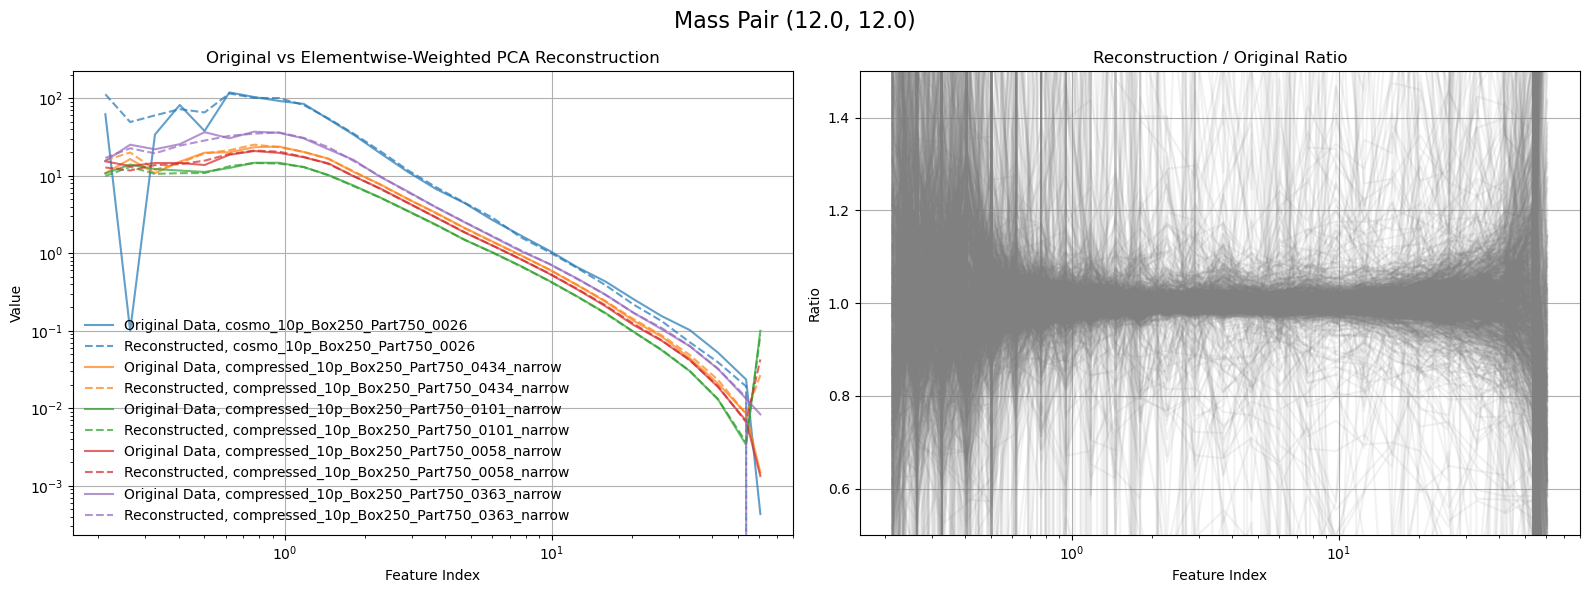

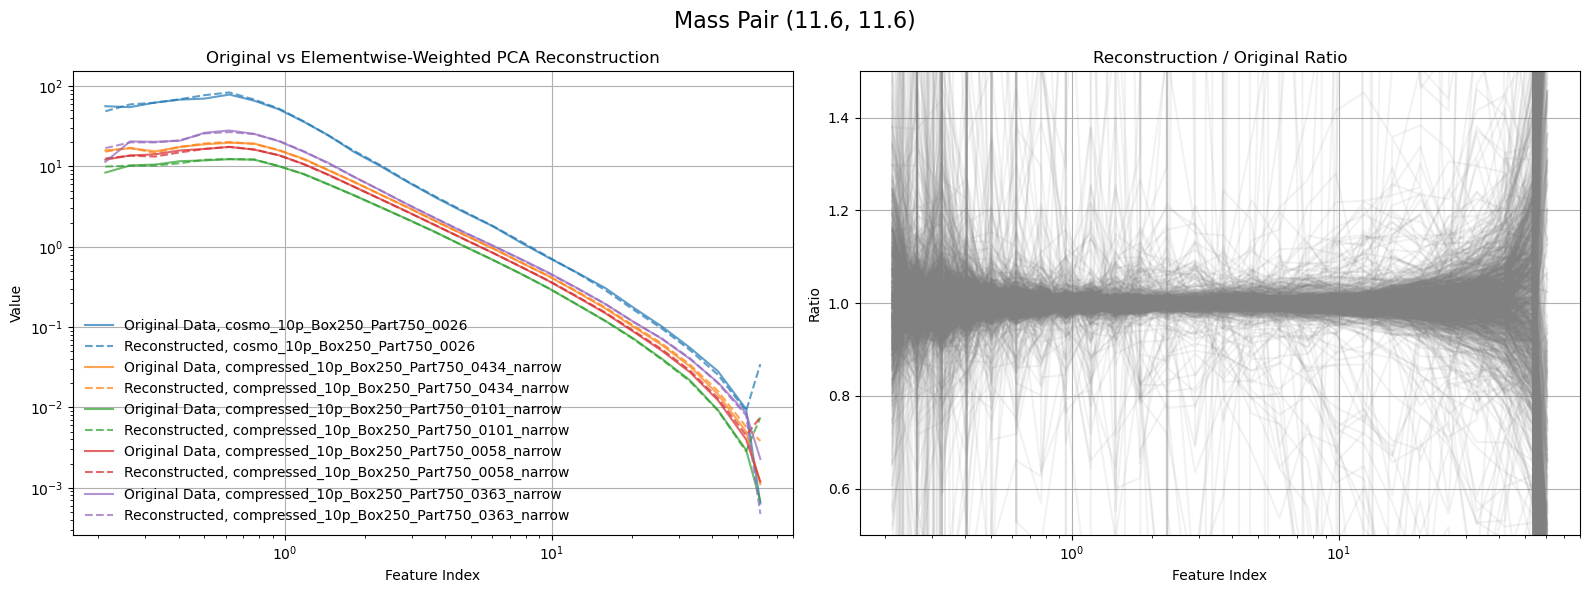

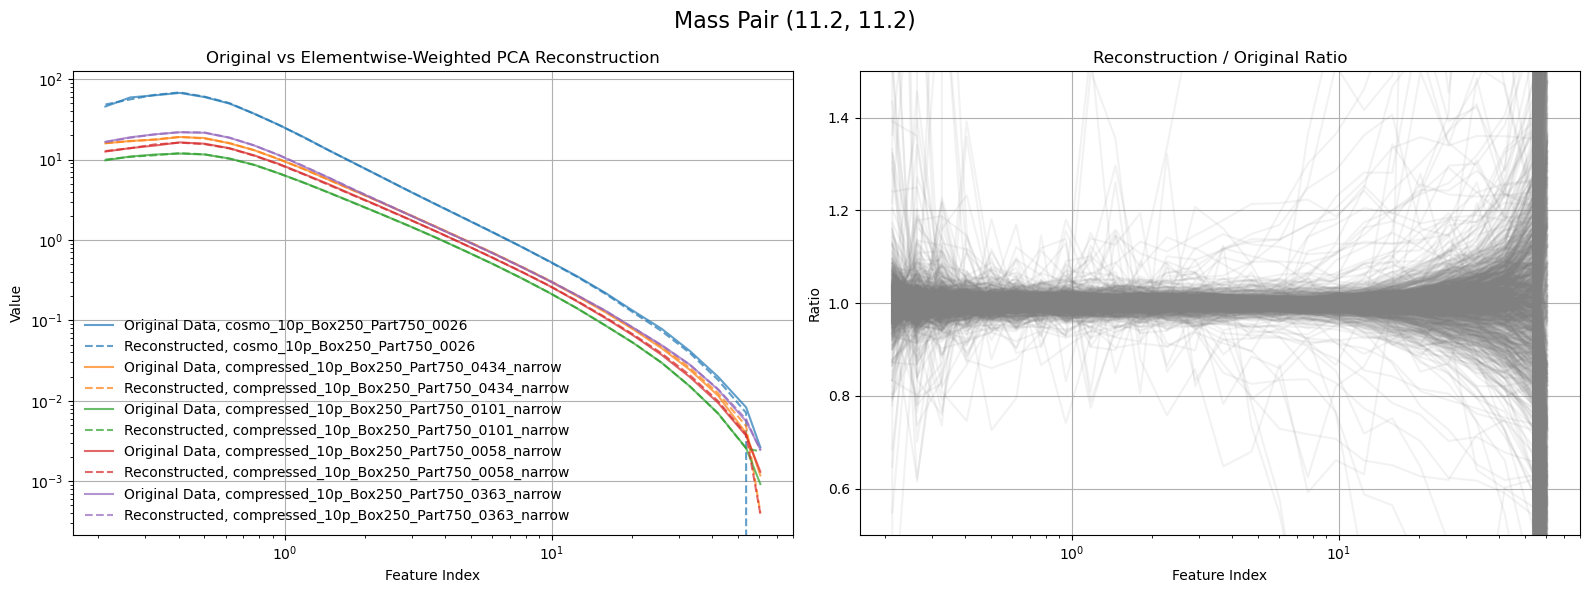

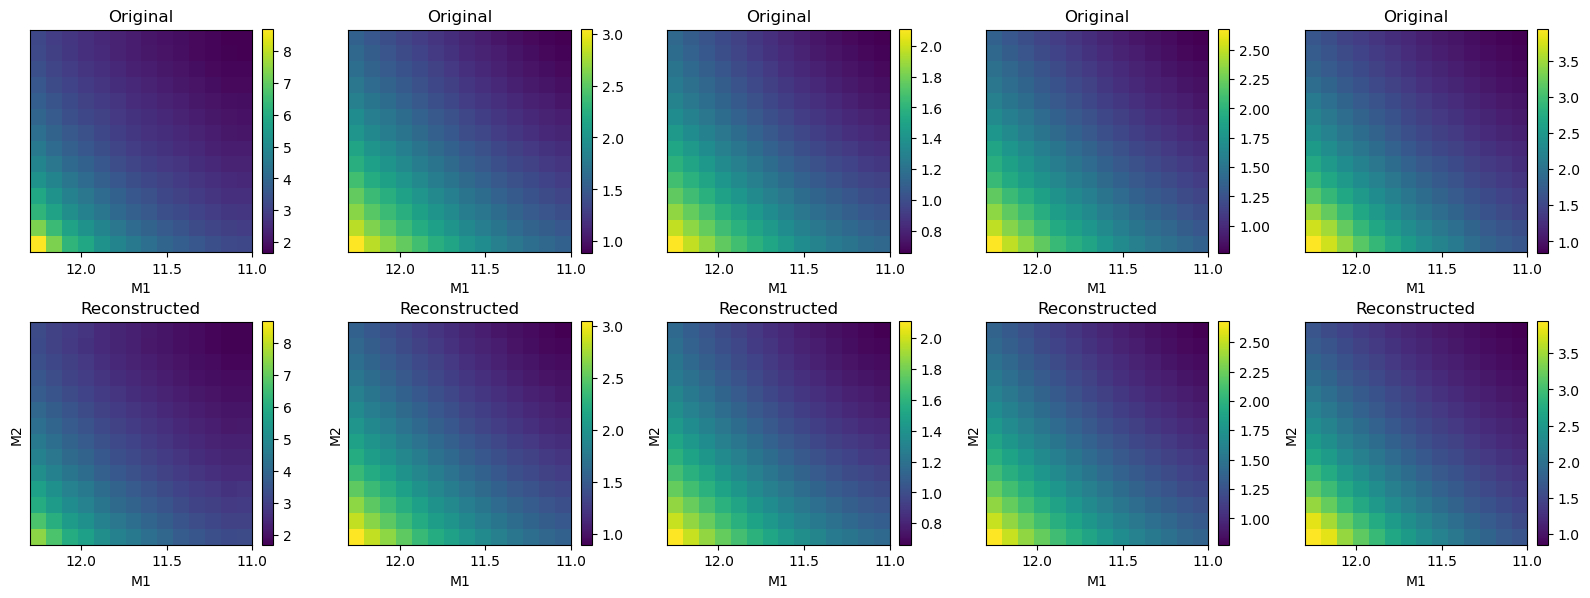

In [135]:
weighted_pca_lf = WeightedPCA(fid='L2', n_components=20)
weighted_pca_hf= WeightedPCA(fid='HF')

weighted_pca_lf.plot_pca(mass_pair=(12.0, 12.0))
weighted_pca_lf.plot_pca(mass_pair=(11.6, 11.6))
weighted_pca_lf.plot_pca(mass_pair=(11.2, 11.2))
weighted_pca_lf.plot_pca_m1m2(rbin=5.0)



## Train on L2, Test on HF:

/home/qezlou/HD2/HETDEX/cosmo/pack_dev/private-gal-emu/src/gal_goku/gal_goku/summary_stats.py:951: RuntimeWarning: invalid value encountered in log10
  log_corr = np.log10(self.xi[:,:,ind_r]).squeeze()


Number of common tags: 1119
n1n2 shape: (1119, 2730), log_hmfs shape: (1119, 24), mbins shape: (24,), indx1 shape: (2730,), indx2 shape: (2730,), weights shape: (1119, 2730)
Cumulative Explained variance ratio: [0.93013522 0.96128264 0.97058144 0.97665208 0.97886249 0.98059336
 0.98195029 0.98324447 0.98415414 0.98492781 0.9856462  0.9863102
 0.98689866 0.98742321 0.98787895 0.98830896 0.98871983 0.98910049
 0.98944856 0.98978041]
Number of common tags: 36
n1n2 shape: (36, 2730), log_hmfs shape: (36, 24), mbins shape: (24,), indx1 shape: (2730,), indx2 shape: (2730,), weights shape: (36, 2730)
Cumulative Explained variance ratio: [0.97498509 0.99009171 0.99713584 0.99902196 0.99936467]


/home/qezlou/HD2/HETDEX/cosmo/pack_dev/private-gal-emu/src/gal_goku/gal_goku/summary_stats.py:951: RuntimeWarning: invalid value encountered in log10
  log_corr = np.log10(self.xi[:,:,ind_r]).squeeze()
/tmp/ipykernel_43236/682017707.py:186: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend(frameon=False)


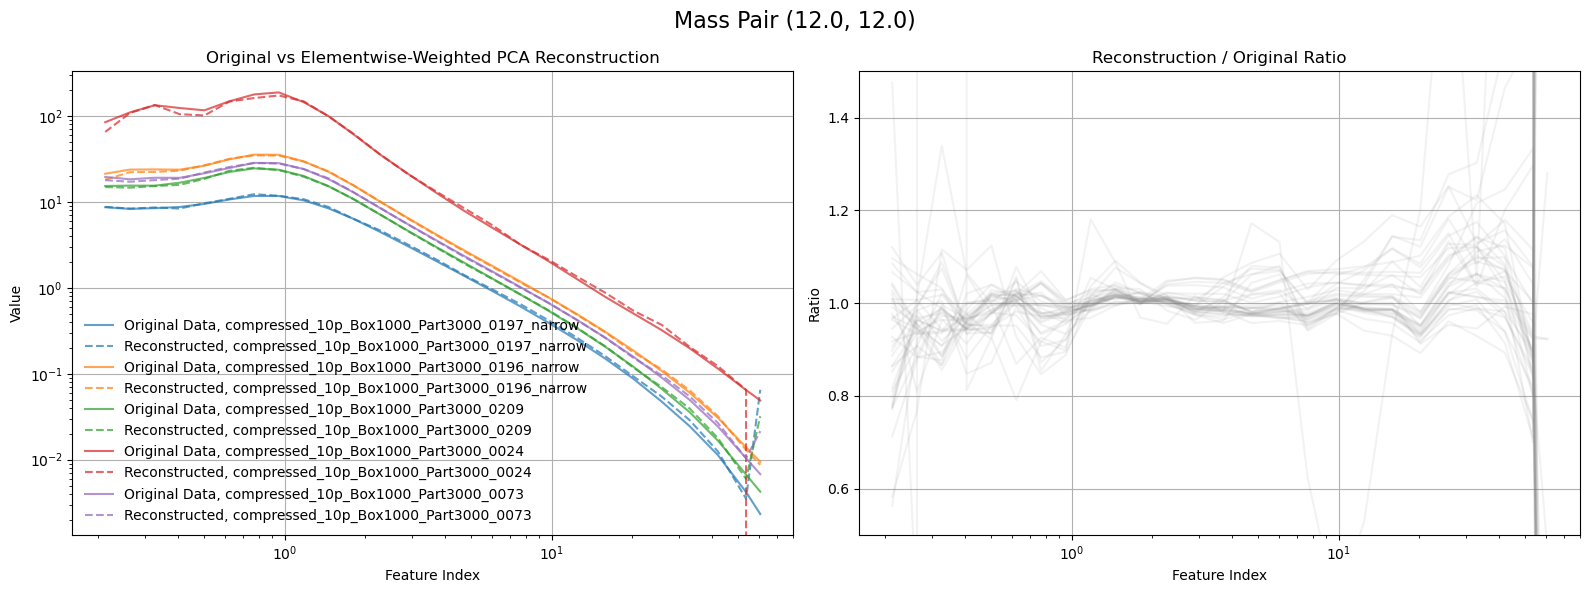

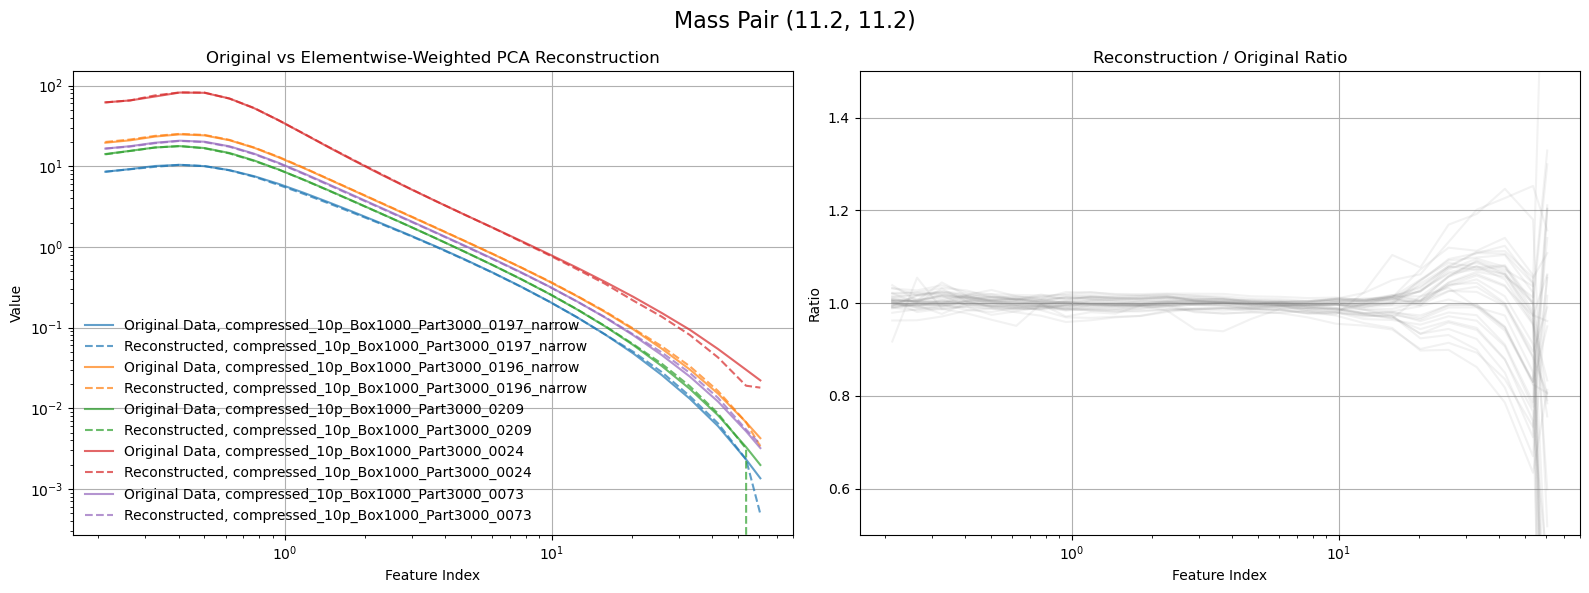

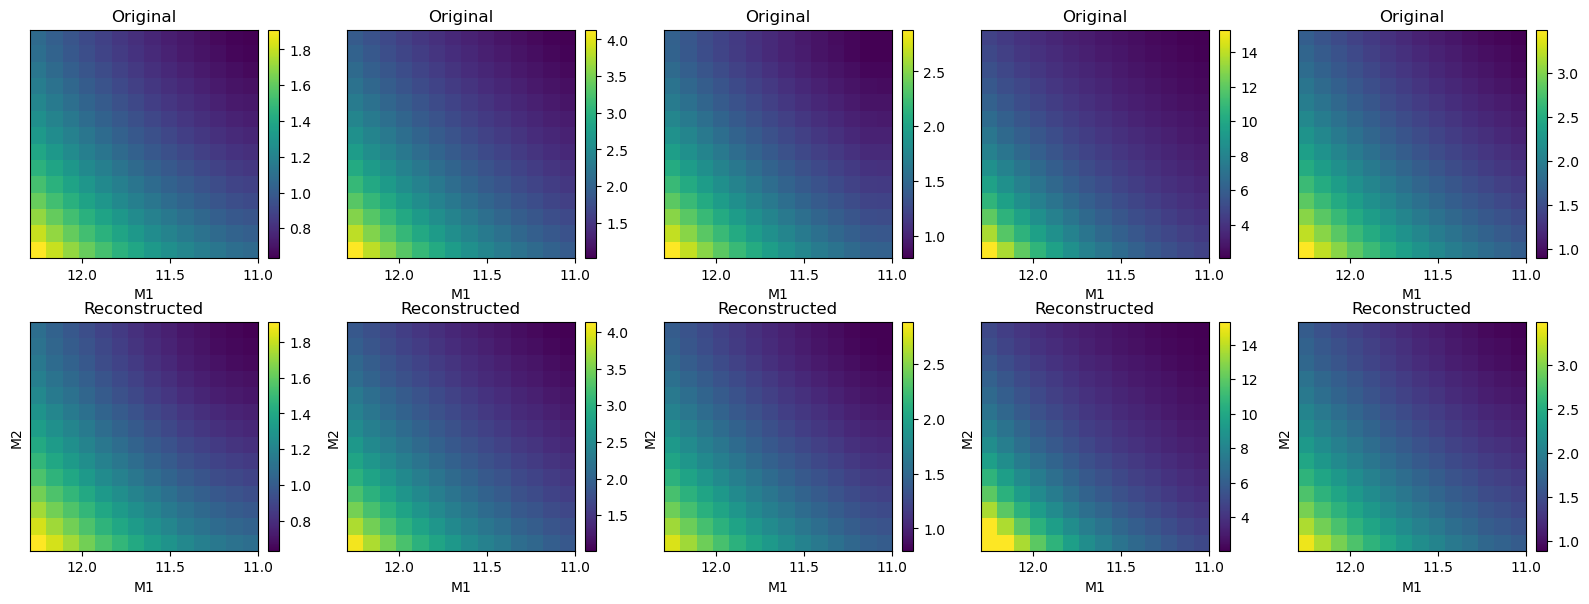

In [129]:
weighted_pca_lf = WeightedPCA(fid='L2', n_components=20)
weighted_pca_hf= WeightedPCA(fid='HF')


X_recontructed = weighted_pca_lf.inverse_transform(weighted_pca_lf.transform(weighted_pca_hf.log_corr, weighted_pca_hf.weights), W=weighted_pca_hf.weights)
weighted_pca_hf.plot_pca(orig=10**weighted_pca_hf.log_corr, reconstructed=X_recontructed, mass_pair=(12.0, 12.0))
weighted_pca_hf.plot_pca(orig=10**weighted_pca_hf.log_corr, reconstructed=X_recontructed, mass_pair=(11.2, 11.2))
weighted_pca_hf.plot_pca_m1m2(orig=10**weighted_pca_hf.log_corr, reconstructed=X_recontructed, rbin=5.0)

## Train on HF Test on L2:

/home/qezlou/HD2/HETDEX/cosmo/pack_dev/private-gal-emu/src/gal_goku/gal_goku/summary_stats.py:951: RuntimeWarning: invalid value encountered in log10
  log_corr = np.log10(self.xi[:,:,ind_r]).squeeze()


Number of common tags: 1119
n1n2 shape: (1119, 2730), log_hmfs shape: (1119, 24), mbins shape: (24,), indx1 shape: (2730,), indx2 shape: (2730,), weights shape: (1119, 2730)
Cumulative Explained variance ratio: [0.93013522 0.96128264 0.97058144 0.97665208 0.97886249]
Number of common tags: 36
n1n2 shape: (36, 2730), log_hmfs shape: (36, 24), mbins shape: (24,), indx1 shape: (2730,), indx2 shape: (2730,), weights shape: (36, 2730)
Cumulative Explained variance ratio: [0.97498509 0.99009171 0.99713584 0.99902196 0.99936467 0.99956749
 0.99969808 0.99980052 0.99985454 0.99988957 0.99991594 0.99993431
 0.99994627 0.9999557  0.99996264 0.99996829 0.99997366 0.99997762
 0.99998073 0.9999833 ]


/home/qezlou/HD2/HETDEX/cosmo/pack_dev/private-gal-emu/src/gal_goku/gal_goku/summary_stats.py:951: RuntimeWarning: invalid value encountered in log10
  log_corr = np.log10(self.xi[:,:,ind_r]).squeeze()
/tmp/ipykernel_43236/682017707.py:186: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend(frameon=False)


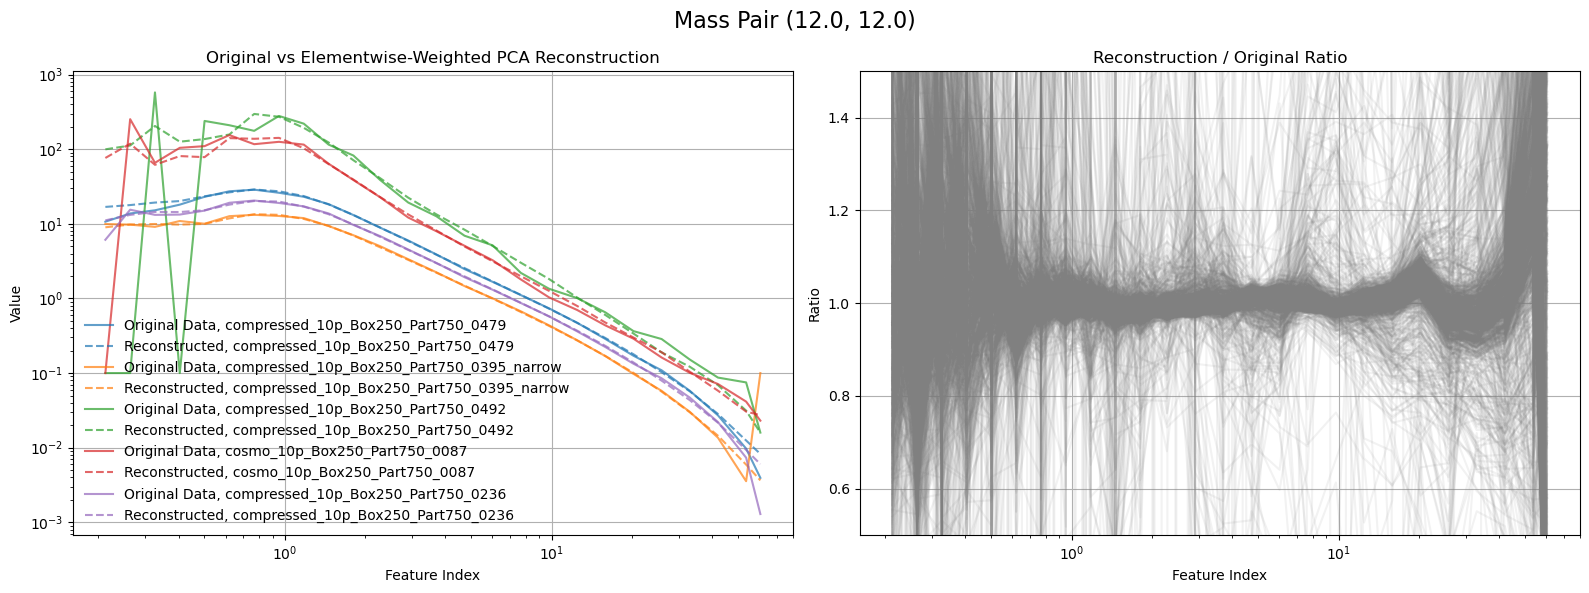

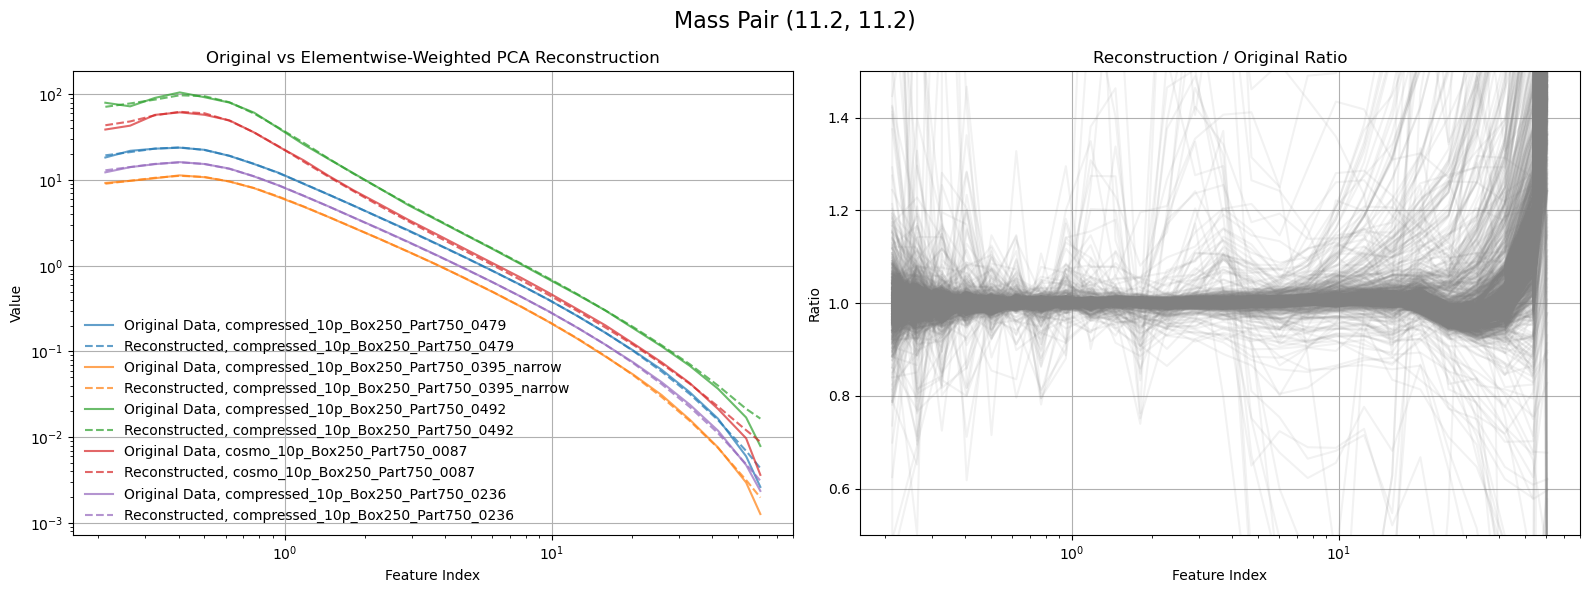

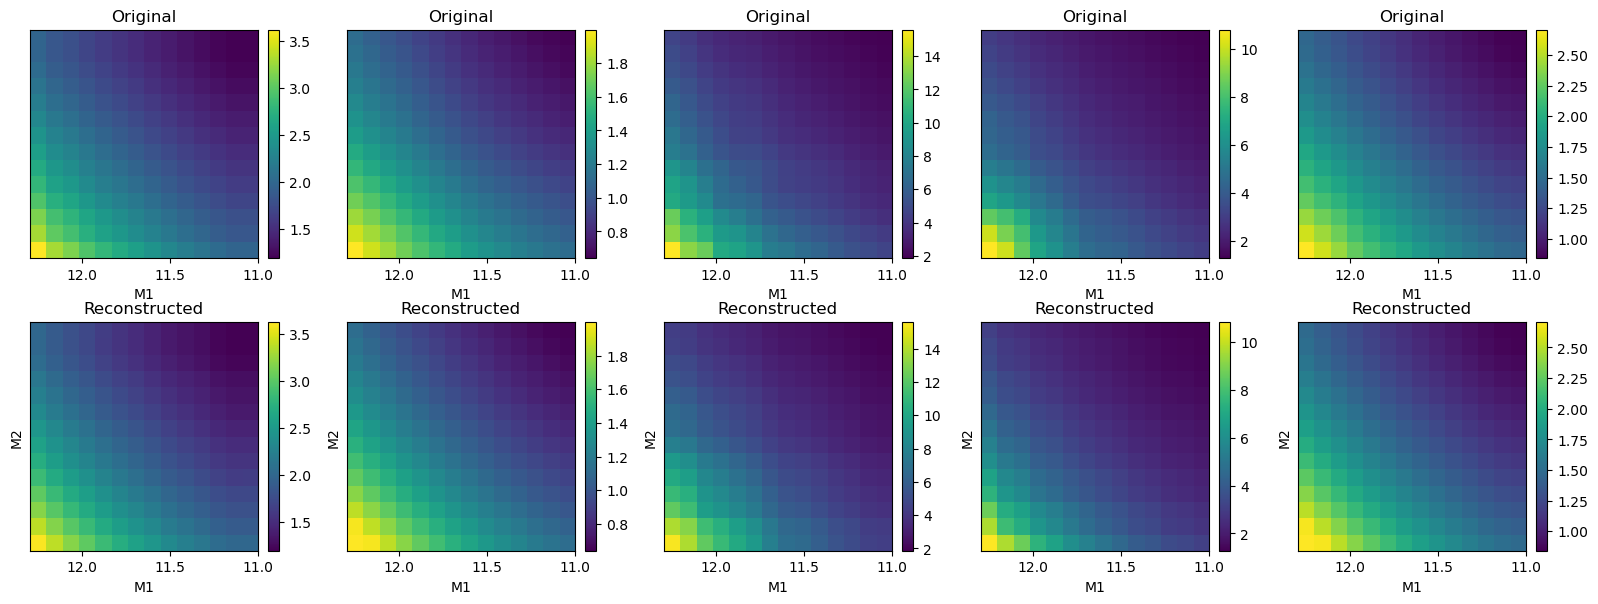

In [131]:
weighted_pca_lf = WeightedPCA(fid='L2')
weighted_pca_hf= WeightedPCA(fid='HF', n_components=20)

X_reconstructed = weighted_pca_hf.inverse_transform(weighted_pca_hf.transform(weighted_pca_lf.log_corr, weighted_pca_lf.weights), W=weighted_pca_lf.weights)
weighted_pca_lf.plot_pca(orig=10**weighted_pca_lf.log_corr, reconstructed=X_reconstructed, mass_pair=(12.0, 12.0))
weighted_pca_lf.plot_pca(orig=10**weighted_pca_lf.log_corr, reconstructed=X_reconstructed, mass_pair=(11.2, 11.2))
weighted_pca_lf.plot_pca_m1m2(orig=10**weighted_pca_lf.log_corr, reconstructed=X_reconstructed, rbin=5.0)

## Conclusion:

We can use ~ 20 principle components, and the reconsructed $\xi$ has proper shaoe in $(M_1, M_2, r)$ dimensions, i.e. learned the trends well.

### Apply to training:

1. We learn the PCs that minimize the loss $\mathcal{L} = (\xi - \hat\xi)^2 + \lambda ...  $ at all $(mass \ pairs, r)$ bins. The training is done on `coeffs = pca.transform()` and `xi_hat = pca.inverse_transform(coeffs, weights)`

2. We need to know the *weights*, for inference. This means the HMF emulator should be used. To assess the introduced uncertainty, we should use that during test (maybe also validation?).

# PCA for HMF:

In [193]:

import numpy as np
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt



class WeightedPCA:
    def __init__(self, fid='L2', mass_cut=12.4, n_components=5):
        self.fid = fid
        self.n_components = n_components
        self.mass_cut = mass_cut

        self.log_hmfs = []
        for narrow in [True, False]:
            data_dir = '/home/qezlou/HD2/HETDEX/cosmo/data/'
            hmf = summary_stats.HMF(data_dir=data_dir, fid=fid, narrow=narrow, logging_level='WARNING')

            mbins, log_hmfs, _, _, sim_tags_hmf = hmf.get_wt_err()
            ind = mbins < self.mass_cut
            self.mbins = mbins[ind]
            self.log_hmfs.append(log_hmfs[:,ind])

        
        self.log_hmfs = np.concatenate(self.log_hmfs, axis=0)

        print('mass bins:', self.mbins, 'original data shape:', self.log_hmfs.shape)

        # Digitize the first two columns of xi_bins using mbins
        self.weights = np.sqrt(1/10**self.log_hmfs)

        self.weights /= self.weights[0][0]

        # Do the PCA
        self.X_reconstructed, self.pca, self.mean_w = self.do_pca(n_components=self.n_components)

        self.sub_sample_plot = np.random.choice(range(self.log_hmfs.shape[0]), size=5, replace=False)

    def do_pca(self, n_components=10):
        """
        Perform PCA on the log_corr data with weights.
        """
        # Original data
        X = 10**self.log_hmfs              # shape: (n_samples, n_features)
        W = self.weights                     # shape: (n_samples, n_features)

        # Mean-centering: use weighted mean for each feature
        weighted_sum = np.sum(X * W, axis=0)
        sum_weights = np.sum(W, axis=0)
        mean_w = weighted_sum / sum_weights  # shape: (n_features,)

        # Center the data
        X_centered = X - mean_w              # broadcast (n_samples, n_features)

        # Apply sqrt of weights to scale residuals
        X_weighted = X_centered * np.sqrt(W)

        # Apply PCA to this transformed data
        pca = PCA(n_components=n_components)
        pca.fit(X_weighted)

        # Transform and reconstruct
        X_proj = pca.transform(X_weighted)
        X_reconstructed_weighted = pca.inverse_transform(X_proj)

        # Undo weighting and re-add mean
        X_reconstructed = X_reconstructed_weighted / np.sqrt(W) + mean_w

        print("Cumulative Explained variance ratio:", np.cumsum(pca.explained_variance_ratio_))

        return X_reconstructed, pca, mean_w


    
    def transform(self, log_hmf, W):
        """
        Transform the log_corr data using the PCA model.
        """
        X = 10**log_hmf

        # Center the data by the already computed mean
        # Use the mean_w computed during PCA fitting
        X_centered = X - self.mean_w

        # Apply sqrt of weights to scale residuals
        X_weighted = X_centered * np.sqrt(W)

        # Transform using PCA
        X_proj = self.pca.transform(X_weighted) # shape: (n_new_samples, n_components)

        return X_proj
    
    def inverse_transform(self, X_proj, W):
        """
        Inverse transform the PCA projection back to the original space.
        """
        # Inverse transform using PCA
        X_reconstructed_weighted = self.pca.inverse_transform(X_proj)

        # Undo weighting and re-add mean
        X_reconstructed = X_reconstructed_weighted / np.sqrt(W) + self.mean_w

        return X_reconstructed

    def plot_pca(self, orig=None, reconstructed=None):

        # Compare original vs reconstructed

        fig, ax = plt.subplots(1, 2, figsize=(16, 6))

        if orig is None:
            orig = 10**self.log_hmfs
            reconstructed = self.X_reconstructed


        for i, ind in enumerate(self.sub_sample_plot):
            # First axis: original vs reconstructed
            ax[0].plot(10**self.mbins, orig[ind], label=f'Original Data', alpha=0.7, color=f'C{i}')
            ax[0].plot(10**self.mbins, reconstructed[ind], label=f'Reconstructed Data', alpha=0.7, color=f'C{i}', linestyle='--')
        ax[0].set_yscale('log')
        ax[0].set_xscale('log')


        # Second axis: ratio
        for ind in range(orig.shape[0]):
            ratio = reconstructed[ind] / orig[ind]
            ax[1].plot(10**self.mbins, ratio, alpha=0.2, color='gray')
        #ax[1].plot(ratio, label='Reconstructed / Original')
        ax[1].set_xlabel('Mass')
        ax[1].set_ylabel('Ratio')
        ax[1].set_title('Reconstruction / Original Ratio')
        ax[1].legend(frameon=False)
        ax[1].grid(True)
        ax[1].set_ylim(0.7, 1.3)
        ax[1].set_xscale('log')

        fig.tight_layout()

    


## Fit on L2, test on L2:

mass bins: [11.15 11.25 11.35 11.45 11.55 11.65 11.75 11.85 11.95 12.05 12.15 12.25
 12.35 12.45] original data shape: (1120, 14)
Cumulative Explained variance ratio: [0.98456571 0.99112651 0.9941373  0.99628797 0.99764091]


/tmp/ipykernel_43236/988728386.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend(frameon=False)


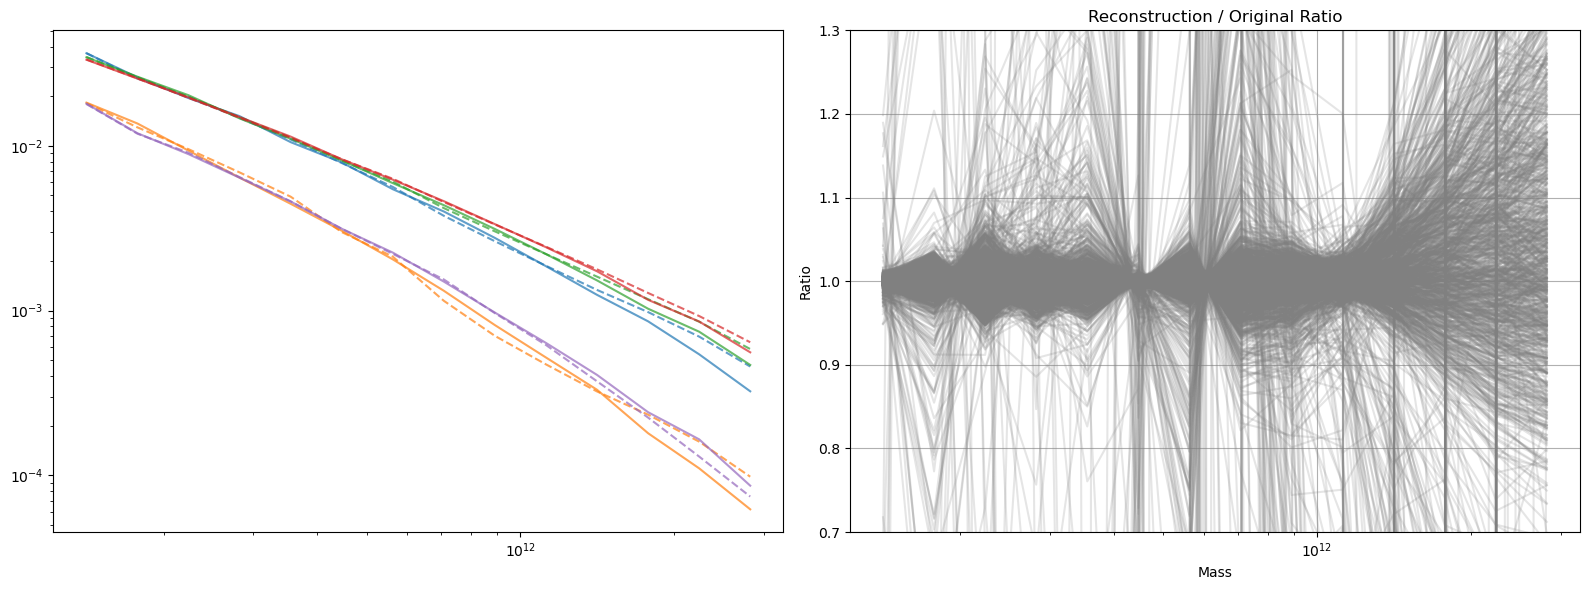

In [196]:
weighted_pca_lf = WeightedPCA(fid='L2', n_components=5, mass_cut=12.5)
weighted_pca_lf.plot_pca()

## Fit on L2, test on HF:

mass bins: [11.15 11.25 11.35 11.45 11.55 11.65 11.75 11.85 11.95 12.05 12.15 12.25
 12.35 12.45] original data shape: (1120, 14)
Cumulative Explained variance ratio: [0.98456571 0.99112651 0.9941373  0.99628797 0.99764091]
mass bins: [11.15 11.25 11.35 11.45 11.55 11.65 11.75 11.85 11.95 12.05 12.15 12.25
 12.35 12.45] original data shape: (36, 14)
Cumulative Explained variance ratio: [0.99266511 0.99808113 0.99925016 0.99977504 0.99989602]


/tmp/ipykernel_43236/988728386.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend(frameon=False)


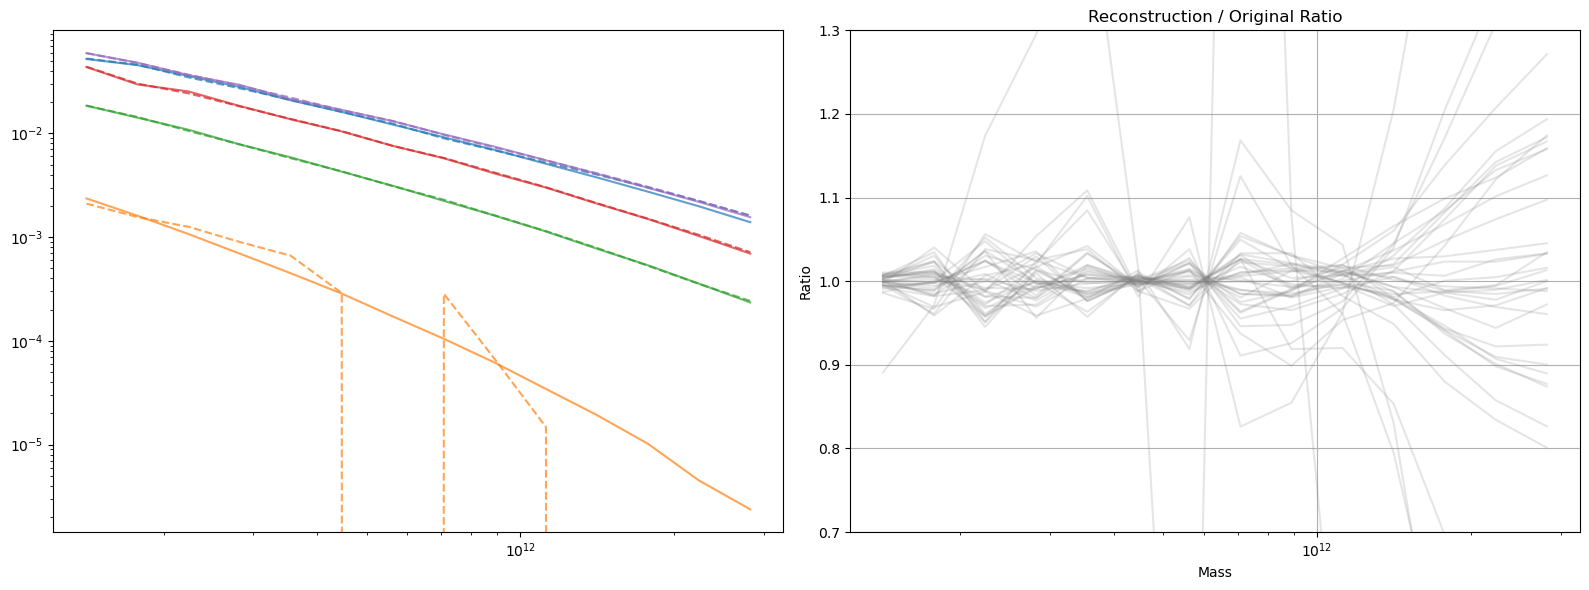

In [221]:
weighted_pca_lf = WeightedPCA(fid='L2', n_components=5, mass_cut=12.5)
weighted_pca_hf= WeightedPCA(fid='HF', mass_cut=12.5)


X_reconstructed = weighted_pca_lf.inverse_transform(weighted_pca_lf.transform(weighted_pca_hf.log_hmfs, weighted_pca_hf.weights), W=weighted_pca_hf.weights)
weighted_pca_hf.plot_pca(orig=10**weighted_pca_hf.log_hmfs, reconstructed=X_reconstructed)

## Fit on HF, test on L2:

mass bins: [11.15 11.25 11.35 11.45 11.55 11.65 11.75 11.85 11.95 12.05 12.15 12.25
 12.35 12.45] original data shape: (36, 14)
Cumulative Explained variance ratio: [0.99266511 0.99808113 0.99925016 0.99977504 0.99989602]
mass bins: [11.15 11.25 11.35 11.45 11.55 11.65 11.75 11.85 11.95 12.05 12.15 12.25
 12.35 12.45] original data shape: (1120, 14)
Cumulative Explained variance ratio: [0.98456571 0.99112651 0.9941373  0.99628797 0.99764091]


/tmp/ipykernel_43236/988728386.py:132: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend(frameon=False)


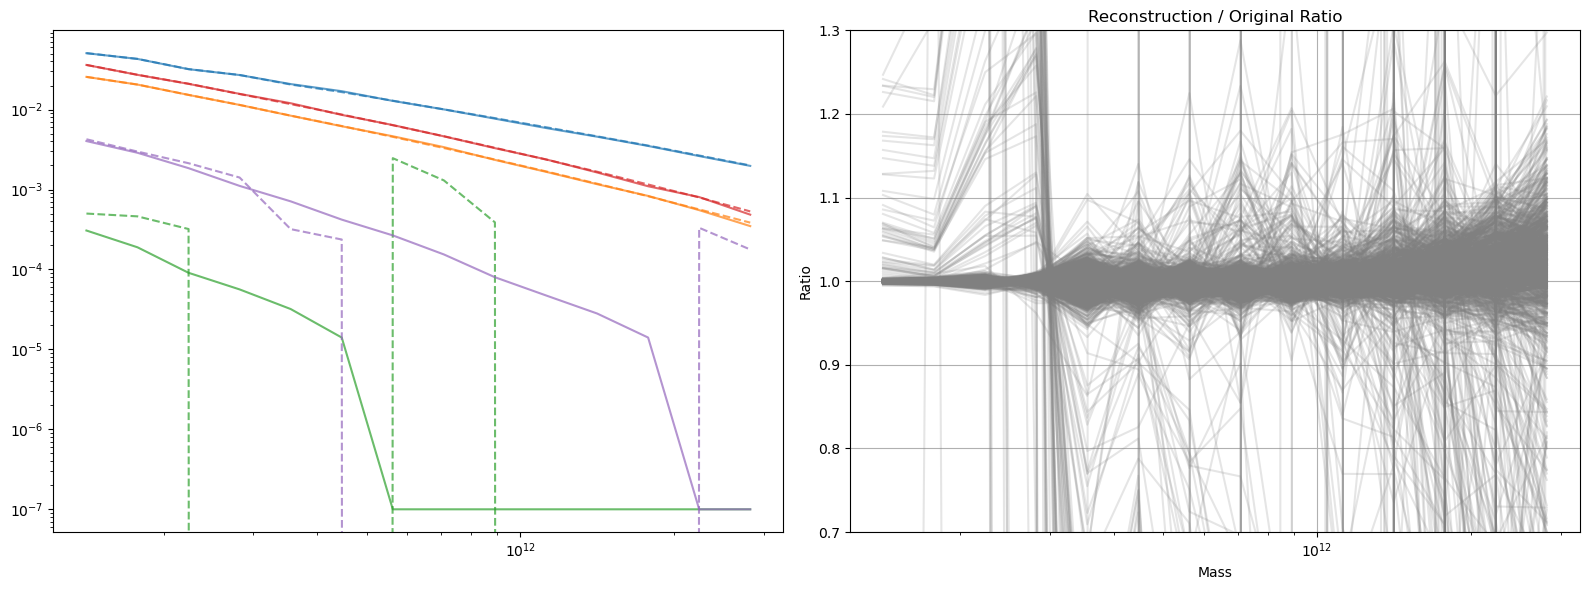

In [210]:
# Fit to HF and test on L2
weighted_pca_hf= WeightedPCA(fid='HF', mass_cut=12.5, n_components=5)
weighted_pca_lf = WeightedPCA(fid='L2', mass_cut=12.5)

X_reconstructed = weighted_pca_hf.inverse_transform(weighted_pca_hf.transform(weighted_pca_lf.log_hmfs, weighted_pca_lf.weights), W=weighted_pca_lf.weights)
weighted_pca_lf.plot_pca(orig=10**weighted_pca_lf.log_hmfs, reconstructed=X_reconstructed)

## conclusion:

It doesn't help much with data reduction as e have 14 mass bins for M < 12.35, so should use it only when we have more redshift bins.